# 0 설정, 설치 임포트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install transformers

In [10]:
import os
os.chdir('/content/drive/MyDrive/015GithubRepos/Dacon_sentence_classification')

import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm, tqdm_notebook
import time
from collections import Counter

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW, AutoModel, AutoModelForSequenceClassification
from transformers.optimization import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

## 경로지정

In [5]:
dataPATH = 'data/'

# 1 하이퍼 파라미터 설정

### epoch

In [6]:
# epoch 5만 해도될듯
num_epochs = 10

### batch_size

In [7]:
batch_size = 10

### learning rate

In [8]:
lr = 0.00001

# 2 Data 처리

## 텍스트 전처리

In [11]:
# dev 데이터 더함

def load_data(dataPATH):
    train = pd.read_csv(dataPATH+'train_data.csv')
    train_dev = pd.read_csv(dataPATH+'train_dev.csv')
    new_df = pd.read_csv(dataPATH+'new_df.csv')
    test = pd.read_csv(dataPATH+'test_data.csv')
    sample_submission = pd.read_csv(dataPATH+'sample_submission.csv')

    train = pd.concat([train,train_dev], ignore_index=True)
    train = pd.concat([train,new_df], ignore_index=True, join='inner')
    train = train.dropna()

    label_dict = {"entailment" : 0, "contradiction" : 1, "neutral" : 2}

    train['label'] = train['label'].map(label_dict)
    train['premise'] = train['premise'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))
    train['hypothesis'] = train['hypothesis'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))
    test['premise'] = test['premise'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))
    test['hypothesis'] = test['hypothesis'].map(lambda x: re.sub('[-=+.,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x))

    return train,test,sample_submission 

def text_clean(df):
    df["premise_"] = "[CLS]" + df["premise"] + "[SEP]"
    df["hypothesis_"] = df["hypothesis"] + "[SEP]"
    df["text_sum"] = df.premise_ + " " + df.hypothesis_
    df = df[['text_sum','label']]

    return df 

train, test, sample_submission = load_data(dataPATH)
clean_train, clean_test = text_clean(train), text_clean(test)


In [12]:
clean_train

,text_sum,label
0,[CLS]씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 ...,1
1,[CLS]삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 ...,1
2,[CLS]이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다[SEP] 예측적 범...,0
3,[CLS]광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민...,2
4,[CLS]진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상...,2
...,...,...
30871,[CLS]GAO는 매일 웹사이트에 오늘의 보고서로 알려진 이 목록을 게시한다[SEP...,0
30872,[CLS]GAO는 매일 웹사이트에 오늘의 보고서로 알려진 이 목록을 게시한다[SEP...,1
30873,[CLS]너무 작아서 상관없어[SEP] 형사가 작다고 무시하는 것은 좋지 않다[SEP],0
30874,[CLS]너무 작아서 상관없어[SEP] 그것은 형사가 작은 것들을 무시하면서 할 수...,2


## CustomDataset 클래스 선언

In [16]:
#%% data loader 

class CustomDataset(Dataset):
  
  def __init__(self, dataset, option, modelname):
    self.dataset = dataset 
    self.option = option
    self.tokenizer = AutoTokenizer.from_pretrained(modelname)
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values  # numpy array
    text = row[0]
    # y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=100,
        pad_to_max_length=True,
        add_special_tokens=False
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    
    if self.option =='train':
        y = row[1]
        return input_ids, attention_mask, y

    return input_ids, attention_mask


# 3 학습

## device 설정

In [17]:
device = torch.device("cuda")
device

device(type='cuda')

## modelname 설정

In [18]:
modelname = 'klue/roberta-large'
# modelname = 'monologg/koelectra-base-v3-discriminator'
modelname

'klue/roberta-large'

## 학습

### 3-1 Cross Validation

In [ ]:
#%% Cross validation 

n_splits = 5

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=42)

folds=[]
for trn_idx, val_idx in skf.split(clean_train['text_sum'], clean_train['label']):
    folds.append((trn_idx,val_idx))

In [ ]:
best_models = []
model_num = 0
for fold in range(5):
    start_time = time.time()
    print(f'=============================={fold+1}fold start==============================')

    # CV용 model 새로 선언
    model = AutoModelForSequenceClassification.from_pretrained(modelname, num_labels=3)
    model = nn.DataParallel(model).to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr)
    
    train_idx = folds[fold][0]
    valid_idx = folds[fold][1]

    train_data = clean_train.loc[train_idx]
    val_data = clean_train.loc[valid_idx]

    train_dataset = CustomDataset(train_data, 'train', modelname)
    valid_dataset = CustomDataset(val_data, 'train', modelname)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    warmup_ratio = 0.1
    total_steps = len(train_loader) * num_epochs
    warmup_step = int(total_steps * warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1, num_training_steps=total_steps)
    valid_loss_min = 0.4
    valid_acc_max = 0.8
    
    
    for epoch in range(num_epochs):  # epoch = 10
        print(f'epoch : {epoch}-----------------------------------------------------------------')
        batches = 0
        total_loss = 0.0
        correct = 0
        total =0
        model.train()  # train 모드로 변경
        
        # 학습데이터로 학습 #############################################################
        print(f'train 학습..........')
        for input_ids_batch, attention_masks_batch, y_batch in train_loader:
            optimizer.zero_grad()  # 그래디언트 초기화
            y_batch = y_batch.to(device)  # y_batch를 gpu 올림
            y_pred = model(input_ids_batch.to(device), attention_mask = attention_masks_batch.to(device))[0]  # 순전파
            loss = F.cross_entropy(y_pred, y_batch)  # loss 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트
            total_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y_batch).sum()
            total += len(y_batch)
            batches += 1
            if batches % 100 == 0:
                acc = correct.float() / total
                print(f'iteration 누적 : {batches}, Train Loss: {total_loss:.4f}, Train Accuracy : {acc.item():.4f}')
        acc = correct.float() / total
        print(f'iteration 누적 : {batches}, Train Loss: {total_loss:.4f}, Train Accuracy : {acc.item():.4f}')
        # 학습데이터로 학습 #############################################################


        # 검증데이터로 검증 #############################################################
        val_loss = []
        val_acc = []
        print(f'validation 검증..........')
        for input_ids_batch, attention_masks_batch, y_batch in valid_loader:
            
            model.eval()
            with torch.no_grad():
                y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
                valid_loss = F.cross_entropy(y_pred,y_batch.to(device)).cpu().detach().numpy()

                preds = torch.argmax(y_pred,1)
                preds = preds.cpu().detach().numpy()
                y_batch = y_batch.cpu().detach().numpy()
                batch_acc = (preds==y_batch).mean()
                val_loss.append(valid_loss)
                val_acc.append(batch_acc)

        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        scheduler.step()
        print(f'Valid Loss: {val_loss:.4f}, Valid Accuracy : {val_acc:.4f}')
        print(f'Learning rate : {optimizer.param_groups[0]["lr"]:.6f}')
        # 검증데이터로 검증 #############################################################

        if valid_acc_max < val_acc:  # 이전보다 좋으면 best_models에 모델을 추가
            valid_acc_max = val_acc
            best_models.append(model)
            torch.save(model, f'koelectra-adddata{model_num}.pth')  # 모델 저장
            model_num += 1
            print(f'model \'koelectra-adddata{model_num}.pth\' save. the number of best_models: {len(best_models)}, model val acc : {val_acc:.6f}******************')
        print(f'--------------------------------------------------------------------------------')

    print(f'{fold+1}fold elapsed time : {time.time() - start_time}')
    

In [ ]:
test_dataset = CustomDataset(clean_test,'test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

preds = []
for idx, m in enumerate(best_models): 
    print(f'{idx+1}/{len(best_models)}번째 모델 예측 진행중')
    bestm = m
    bestm.eval()
    answer = []
    with torch.no_grad():
        for input_ids_batch, attention_masks_batch in tqdm(test_loader):
            y_pred = bestm(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0].detach().cpu().numpy()
            answer.extend(y_pred.argmax(axis=1))
            
    preds.append(answer)

### 3-2 단일모델 10에폭

In [ ]:
start_time = time.time()

# model 선언
model = AutoModelForSequenceClassification.from_pretrained(modelname, num_labels=3)
model = nn.DataParallel(model).to(device)

optimizer = AdamW(model.parameters(), lr=lr)

train_dataset = CustomDataset(clean_train, 'train', modelname)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

warmup_ratio = 0.1
total_steps = len(train_loader) * num_epochs
warmup_step = int(total_steps * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=1, num_training_steps=total_steps)


for epoch in range(num_epochs):  # epoch = 10
    print(f'epoch : {epoch}-----------------------------------------------------------------')
    batches = 0
    total_loss = 0.0
    correct = 0
    total =0

    model.train()  # train 모드로 변경
    
    # 학습데이터로 학습 #############################################################
    print(f'train 학습..........')
    for input_ids_batch, attention_masks_batch, y_batch in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        y_batch = y_batch.to(device)  # y_batch를 gpu 올림
        y_pred = model(input_ids_batch.to(device), attention_mask = attention_masks_batch.to(device))[0]  # 순전파
        loss = F.cross_entropy(y_pred, y_batch)  # loss 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        scheduler.step()
        total_loss += loss.item()
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y_batch).sum()
        total += len(y_batch)
        batches += 1
        if batches % 100 == 0:
            acc = correct.float() / total
            print(f'Batch 누적 : {batches}, Train Loss: {total_loss:.4f}, Train Accuracy : {acc.item():.4f}')
    acc = correct.float() / total
    print(f'iteration 누적 : {batches}, Train Loss: {total_loss:.4f}, Train Accuracy : {acc.item():.4f}')
    # 학습데이터로 학습 #############################################################

print(f'elapsed time : {time.time() - start_time}')

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

epoch : 0-----------------------------------------------------------------
train 학습..........
Batch 누적 : 100, Train Loss: 110.3898, Train Accuracy : 0.3570
Batch 누적 : 200, Train Loss: 199.6197, Train Accuracy : 0.4640


In [ ]:
torch.save(model, 'roberta_33427.pth')

# 4 불러와서 예측

In [ ]:
# import time

# test_dataset = CustomDataset(clean_test,'test')
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
# preds = []
# for _ in range(13):
#     start = time.time()
#     print(f'{_+1}/13 번째 모델 예측 진행중')
#     m = torch.load(f'roberta-large-adddata{_}.pth')
#     m.eval()
#     answer = []
#     with torch.no_grad():
#         for input_ids_batch, attention_masks_batch in tqdm(test_loader):
#             y_pred = m(
#                 input_ids_batch.to(device),
#                 attention_mask=attention_masks_batch.to(device)
#                 )[0].detach().cpu().numpy()
#             answer.extend(y_pred.argmax(axis=1))
            
#     preds.append(answer)
#     print(f'elapsed time : {time.time() - start}')

## 여러 모델

In [ ]:
import time

test_dataset = CustomDataset(clean_test,'test', modelname)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
preds = []
for _ in range(23):
    start = time.time()
    print(f'{_+1}/23 번째 모델 예측 진행중')
    m = torch.load(f'koelectra-adddata{_}.pth')
    m.eval()
    answer = []
    with torch.no_grad():
        for input_ids_batch, attention_masks_batch in tqdm(test_loader):
            y_pred = m(
                input_ids_batch.to(device),
                attention_mask=attention_masks_batch.to(device)
                )[0].detach().cpu().numpy()
            answer.extend(y_pred.argmax(axis=1))
            
    preds.append(answer)
    print(f'elapsed time : {time.time() - start}')

1/23 번째 모델 예측 진행중


KeyboardInterrupt: ignored

## 단일 모델

In [ ]:
import time

test_dataset = CustomDataset(clean_test,'test', modelname)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
preds = []

start = time.time()
m = torch.load('roberta_33427.pth')
m.eval()
answer = []
with torch.no_grad():
    for input_ids_batch, attention_masks_batch in tqdm(test_loader):
        y_pred = m(
            input_ids_batch.to(device),
            attention_mask=attention_masks_batch.to(device)
            )[0].detach().cpu().numpy()
        answer.extend(y_pred.argmax(axis=1))
        
preds.append(answer)
print(f'elapsed time : {time.time() - start}')



Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

100%|██████████| 27/27 [00:34<00:00,  1.28s/it]

elapsed time : 63.693918228149414


## 제출

In [ ]:
from collections import Counter

np_pred = np.array(preds).T

pred = []
for i in range(1666):
    cnt = Counter(np_pred[i])
    pred.append(cnt.most_common()[0][0])

In [ ]:
label_dict1 = {0:"entailment" , 1: "contradiction" , 2:"neutral"}

sample_submission['label'] = [label_dict1[_] for _ in pred]

In [ ]:
for _ in np_pred[:50]:
    print(f'{_}\t{Counter(_).most_common()[0][0]}\t{Counter(_)}')

[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[0]	0	Counter({0: 1})
[1]	1	Counter({1: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[0]	0	Counter({0: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[0]	0	Counter({0: 1})
[1]	1	Counter({1: 1})
[0]	0	Counter({0: 1})
[2]	2	Counter({2: 1})
[2]	2	Counter({2: 1})
[2]	2	Counter({2: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[0]	0	Counter({0: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[0]	0	Counter({0: 1})
[0]	0	Counter({0: 1})
[0]	0	Counter({0: 1})
[0]	0	Counter({0: 1})
[1]	1	Counter({1: 1})
[0]	0	Counter({0: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[1]	1	Counter({1: 1})
[0]	0	Counter({0: 1})
[1]	1	Counter({1: 1})
[2]	2	Counter({2: 1})
[0]	0	Counter({0: 1})
[0]	0	Counter({0: 1})
[2]	2	Counter({2: 1})
[2]	2	Counter({2: 1})
[1]	1	Coun

In [ ]:
sample_submission.to_csv(dataPATH + 'roberta_33427.csv', index=False)

# 5 불러와서 앙상블

In [57]:
def soft_max(x):
    
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

## roberta-large205_30876.pth

In [90]:
import time


modelname = 'klue/roberta-large'
print(f'불러오는 model name : {modelname}')

test_dataset = CustomDataset(clean_test,'test', modelname)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

불러오는 model name : klue/roberta-large


In [59]:
sum_probs = np.zeros((test_dataset.dataset.shape[0], 3), dtype = 'f')  # 모델들 예측 확률 더할 곳

In [91]:

# 모델 1개로 예측 ----------------------------------------------------------
start = time.time()
m = torch.load('roberta-large205_30876.pth')
m.eval()
roberta_large_probs = np.empty((0,3), float)

with torch.no_grad():
    for input_ids_batch, attention_masks_batch in tqdm(test_loader):
        # 예측 ------------------------------
        y_pred = m(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0].detach().cpu().numpy()
        roberta_large_probs = np.vstack((roberta_large_probs, soft_max(np.array(y_pred))))  # 3가지 클래스에 대한 확률값. 행렬 shape : 사이즈 X 3
        


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


In [61]:
sum_probs += roberta_large_probs  # 예측 끝나면 더해줌 ********************************
print(f'elapsed time : {time.time() - start}')
# 모델 1개로 예측 ----------------------------------------------------------

elapsed time : 36.25136041641235


In [62]:
sum_probs

array([[1.5169133e-04, 9.9978286e-01, 6.5471810e-05],
       [8.4974704e-04, 3.6687808e-05, 9.9911350e-01],
       [9.9993825e-01, 3.3856275e-05, 2.7882921e-05],
       ...,
       [8.2380255e-05, 1.4439355e-05, 9.9990320e-01],
       [2.4900612e-05, 2.7385238e-05, 9.9994767e-01],
       [1.2892437e-01, 2.1402426e-03, 8.6893547e-01]], dtype=float32)

## KoELECTRA

In [92]:
modelname = 'monologg/koelectra-base-v3-discriminator'  # 토크나이저를 위해 test셋 선언에 필요함
print(f'불러오는 model name : {modelname}')

test_dataset = CustomDataset(clean_test,'test', modelname)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# 모델 1개로 예측 ----------------------------------------------------------
start = time.time()
m = torch.load(f'koelectra205_30876.pth')
m.eval()
electra_probs = np.empty((0,3), float)

with torch.no_grad():
    for input_ids_batch, attention_masks_batch in tqdm(test_loader):
        y_pred = m(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0].detach().cpu().numpy()
        electra_probs = np.vstack((electra_probs, soft_max(np.array(y_pred))))  # 3가지 클래스에 대한 확률값. 행렬 shape : 사이즈 X 3


불러오는 model name : monologg/koelectra-base-v3-discriminator


100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


In [ ]:
sum_probs += electra_probs  # 예측 끝나면 더해줌 ********************************
print(f'elapsed time : {time.time() - start}')
# 모델 1개로 예측 ----------------------------------------------------------

In [ ]:
sum_probs

array([[2.03141361e-04, 1.99964571e+00, 1.51215092e-04],
       [1.06572127e-03, 9.54145289e-05, 1.99883878e+00],
       [1.99450552e+00, 1.03034974e-04, 5.39144129e-03],
       ...,
       [2.85397083e-01, 2.61923618e-04, 1.71434093e+00],
       [8.51145014e-05, 9.87079256e-05, 1.99981606e+00],
       [1.32485151e-01, 1.02617275e-02, 1.85725331e+00]], dtype=float32)

## KoBERT

In [65]:
import pickle
with open('kobert_pred.pkl', 'rb') as f:
    kobert_probs = pickle.load(f)

In [66]:
kobert_probs[0]

array([7.40597316e-04, 9.97669160e-01, 1.59018370e-03])

In [67]:
sum_probs += kobert_probs

## roberta-base

In [48]:
import numpy as np
import pandas as pd

from transformers import pipeline, AutoTokenizer
from tqdm import tqdm

In [68]:
tokenizer = AutoTokenizer.from_pretrained("Huffon/klue-roberta-base-nli")
model = pipeline("text-classification", model="Huffon/klue-roberta-base-nli", return_all_scores=True)

In [69]:
df_test = pd.read_csv("data/test_data.csv")
X_test = df_test["premise"] + " " + tokenizer.sep_token + " " + df_test["hypothesis"]

In [70]:
X_test

0       다만 조금 좁아서 케리어를 펼치기 불편합니다. [SEP] 케리어를 펼치기에 공간이 ...
1       그리고 위치가 시먼역보다는 샤오난먼역에 가까워요 [SEP] 시먼역보다는 샤오난먼역에...
2       구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다. [SEP] 무엇인가 말...
3           몇 번을 다시봐도 볼 때마다 가슴이 저민다. [SEP] 다시 봤을때는 무덤덤했다.
4       8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다. [...
                              ...                        
1661    또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...
1662    결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다. [SEP] 결말을 보니 ...
1663    사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...
1664    로마에서 3박4일간 이곳에서 머물렀습니다. [SEP] 이곳에서 머무르며 로마의 명소...
1665    난 당신이 떠날때 길 하나도 못 건넜는데 [SEP] 난 당신이 떤나 사실도 모르고 ...
Length: 1666, dtype: object

In [53]:
X_test[0]

'다만 조금 좁아서 케리어를 펼치기 불편합니다. [SEP] 케리어를 펼치기에 공간이 충분했습니다.'

In [74]:
model(X_test[0])[0][0]

{'label': 'ENTAILMENT', 'score': 0.0004351639363449067}

In [76]:
model(X_test[0])[0][1]['score']

{'label': 'NEUTRAL', 'score': 0.00032993577769957483}

In [77]:
model(X_test[0])[0][2]

{'label': 'CONTRADICTION', 'score': 0.9992349147796631}

In [ ]:
probs = np.empty((0,3), float)

In [78]:
X_test.size

1666

In [81]:
robert_base_prob = np.empty((0,3), float)
robert_base_prob

array([], shape=(0, 3), dtype=float64)

In [82]:
model(X_test[0])[0][1]['score']

0.00032993577769957483

In [85]:
preds = model(X_test[0])[0]

In [86]:
for_one = [preds[0]['score'], preds[2]['score'], preds[1]['score']]
for_one

[0.0004351639363449067, 0.9992349147796631, 0.00032993577769957483]

In [ ]:
robert_base_prob = np.vstack((robert_base_prob, )) 

In [88]:
robert_base_prob = np.empty((0,3), float)
for i in tqdm(range(X_test.shape[0])):
    # y_pred = model(X_test[i])[0]["label"].lower()
    preds = model(X_test[i])[0]
    for_one = [preds[0]['score'], preds[2]['score'], preds[1]['score']]
    robert_base_prob = np.vstack((robert_base_prob, for_one)) 

# y_preds = np.array(y_preds)

100%|██████████| 1666/1666 [02:41<00:00, 10.35it/s]


## Pororo

In [1]:
# konlpy 설치
!pip install konlpy

     |████████████████████████████████| 19.4 MB 4.1 MB/s 
     |████████████████████████████████| 448 kB 63.1 MB/s 


In [2]:
# Pororo 설치
!pip install git+https://github.com/kakaobrain/pororo.git

  Cloning https://github.com/kakaobrain/pororo.git to /tmp/pip-req-build-5ynboamy
  Running command git clone -q https://github.com/kakaobrain/pororo.git /tmp/pip-req-build-5ynboamy
     |████████████████████████████████| 748.8 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 55.4 MB/s 
     |████████████████████████████████| 1.7 MB 54.0 MB/s 
     |████████████████████████████████| 3.5 MB 63.6 MB/s 
     |████████████████████████████████| 79 kB 11.1 MB/s 
     |████████████████████████████████| 1.5 MB 82.2 MB/s 
     |████████████████████████████████| 3.1 MB 63.6 MB/s 
     |████████████████████████████████| 468 kB 62.4 MB/s 
     |████████████████████████████████| 1.2 MB 17.4 MB/s 
     |████████████████████████████████| 42.4 MB 309 kB/s 
     |████████████████████████████████| 145 kB 80.1 MB/s 
     |████████████████████████████████| 90 kB 14.3 MB/s 
     |████████████████████████████████| 748 kB 74.6 MB/s 
     |████████████████████████████████| 1.2 MB 16.4 MB/s 
     |██

In [ ]:
# mecab 형태소 분석기 설치
!pip install python-mecab-ko

     |████████████████████████████████| 211 kB 4.2 MB/s 
  ERROR: Failed building wheel for python-mecab-ko
  Running setup.py clean for python-mecab-ko
Failed to build python-mecab-ko


In [ ]:
# 예제 실행을 위한 사전 import
from pororo import Pororo



nli_module = Pororo(task="nli", lang="ko")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

As of now, this beta model tries to correct spacing errors in Korean text.


Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/109 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


## 확률 확인

In [93]:
roberta_large_probs[:5]

array([[1.51691333e-04, 9.99782860e-01, 6.54718096e-05],
       [8.49747041e-04, 3.66878085e-05, 9.99113500e-01],
       [9.99938250e-01, 3.38562750e-05, 2.78829211e-05],
       [1.10089313e-04, 9.99790370e-01, 9.95001974e-05],
       [9.90789995e-05, 9.99833107e-01, 6.78400975e-05]])

In [98]:
import matplotlib.pyplot as plt

In [101]:
roberta_large_probs[0]

array([1.51691333e-04, 9.99782860e-01, 6.54718096e-05])

다만 조금 좁아서 케리어를 펼치기 불편합니다. [SEP] 케리어를 펼치기에 공간이 충분했습니다.


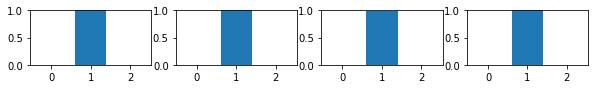

-----------------------------------------
그리고 위치가 시먼역보다는 샤오난먼역에 가까워요 [SEP] 시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요


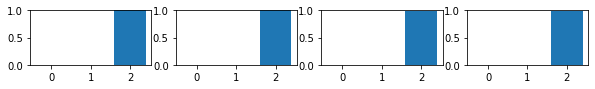

-----------------------------------------
구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다. [SEP] 무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.


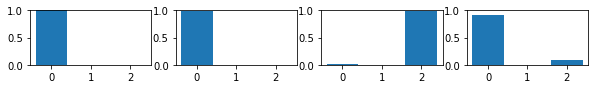

-----------------------------------------
몇 번을 다시봐도 볼 때마다 가슴이 저민다. [SEP] 다시 봤을때는 무덤덤했다.


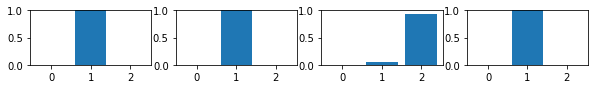

-----------------------------------------
8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다. [SEP] 8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.


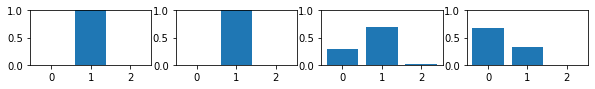

-----------------------------------------
마지막에 존트라볼타 지하철에서 혼자 담배 무는 장면 압권이네요. [SEP] 존트라볼타 지하철에서는 원칙상 담배를 피면 안된다.


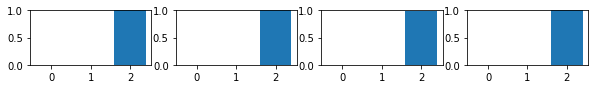

-----------------------------------------
18일 귀국이라 발인도 지켜드리지 못해 더욱 죄송할 따름입니다. [SEP] 18일 배를 타고 여행을 떠났습니다.


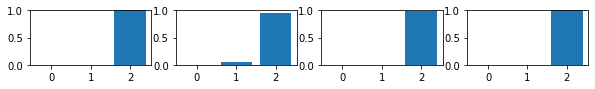

-----------------------------------------
2003년 변정수 씨가 교통사고로 죽었다는 이야기가 돌았지만 사실무근이었다. [SEP] 2003년 변정수 씨는 교통사고를 당했다.


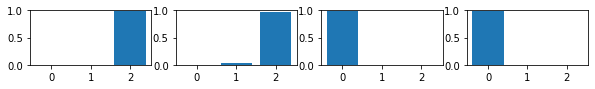

-----------------------------------------
성룡의 초기 전성기를 만들어준 또 하나의 역작 [SEP] 성룡은 초기에 전성기를 맞았다.


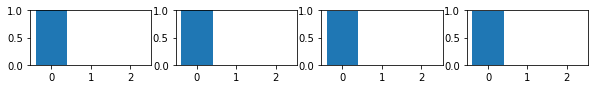

-----------------------------------------
2015년 10월 임관해 사건 당시 대위였던 손씨는 수개월 뒤인 2018년 7월에 전역할 예정이었다. [SEP] 손씨가 전역한 이후에 사건이 일어났다.


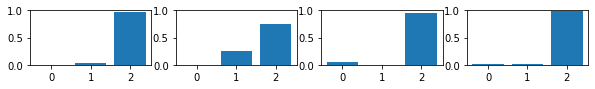

-----------------------------------------
5월 26일 방송된 집방문 또한 무례하기 짝이 없는 자충수. [SEP] 방송에서는 예의를 갖추어 집을 방문했다.


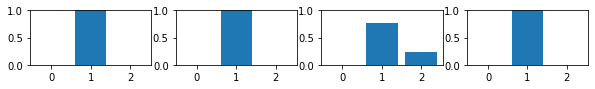

-----------------------------------------
2년 후인 2015년 6월 첫딸을 출산했다. [SEP] 2년 후에 첫 딸아이를 낳았다.


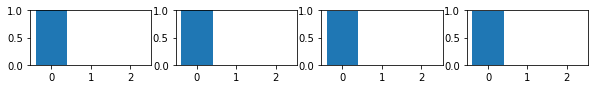

-----------------------------------------
기업공감 절차혁신과 관련해서는 농기자재 수출기업육성 지원절차를 간소화한다. [SEP] 농기자재 수출기업육성 지원절차를 더욱 까다롭게하여 절차혁신을 이룰 예정이다.


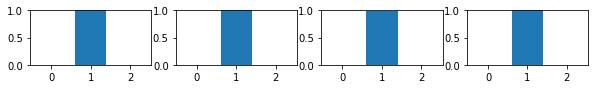

-----------------------------------------
기존에 700억원에 이르는 추진체 발사 비용은 500억으로 약 3분의 1을 절감한 셈이다. [SEP] 추진체의 발사 비용은 원래 500억이었다.


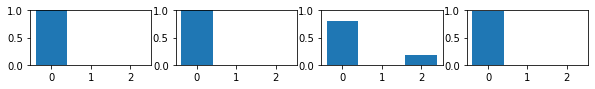

-----------------------------------------
가격이 저렴한데는 이유가 있는것 같네요. [SEP] 가격이 저렴한 만큼 품질이 훌륭하지 않은 것 같습니다.


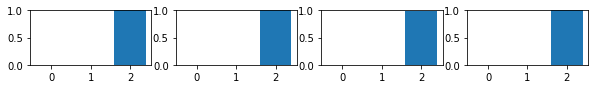

-----------------------------------------
불편사항은 24시간 신고할 수 있다. [SEP] 건의사항도 24시간 신고할 수 있다.


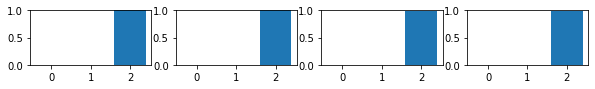

-----------------------------------------
마지막 아이가 우는 장면과 최민수가 맞는 장면이 교차되는게 왜 이리 슬프던지 [SEP] 마지막 장면은 아주 슬펐다.


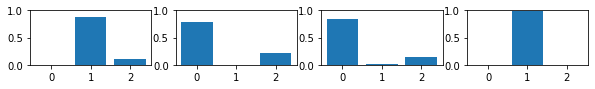

-----------------------------------------
그리고 2층침대는 성인남자가 숙박하기에는 길이가 짧습니다 [SEP] 그 2층 침대는 일본에서 만든 제품입니다.


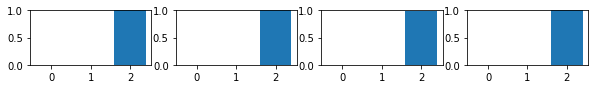

-----------------------------------------
반크는 사이버외교사절단으로 철저하게 비정부기구이고 비영리단체입니다. [SEP] 반크는 이윤을 추구하는 단체이다.


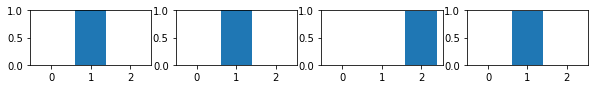

-----------------------------------------
거주하는 동안 불편함없이 잘 지냈습니다 [SEP] 6개월 동안 거주했습니다.


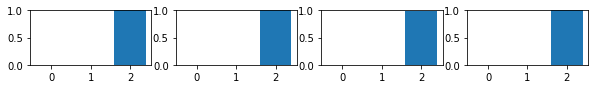

-----------------------------------------
경제를 같이 잘 살려보자는 취지로 시작된 정책이니만큼 일본당국도 빠르게 잘 지급하도록 노력해야 한다. [SEP] 일본당국은 지급할 노력을 하지 않을 것으로 예상된다.


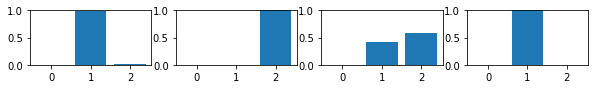

-----------------------------------------
수영구 남천동에 사는 김은경 씨는 태풍 차바가 지나간 직후인 5일 오후 4시경 광안리해수욕장 인근 도로를 걷고 있었다. [SEP] 김은경씨는 태풍 차바가 지나가고 물에 잠긴 인근 도로를 걷고 있었다.


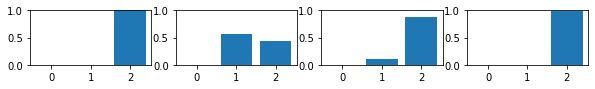

-----------------------------------------
현재 장성택의 매형인 전영진 쿠바 주재 북한 대사와 조카인 장용철 말레이시아 대사도 조선민주주의인민공화국 본국으로 소환된 것으로 전해졌다. [SEP] 전영진과 장용철은 조산민주주의인민공화국 출신이다.


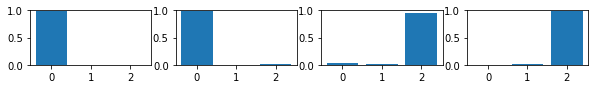

-----------------------------------------
아시아나 항공 보잉 777기가 샌프란시스코 국제공항에 현지시각 6일 11시 30분에 착륙 도중 추락하였다. [SEP] 아시아나 항공 보잉 777기가 추락한 곳은 샌프란시스코 국제공항이다.


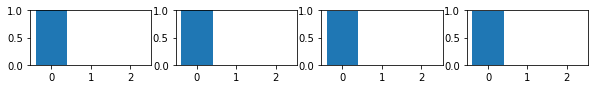

-----------------------------------------
5월 17일 개막식에는 전라남도 김영록 도지사를 비롯한 지방자치단체장 등 각계각층의 인사들이 참석하여 자리를 빛냈다. [SEP] 개막식에는 지방자치단체장만 참석했다.


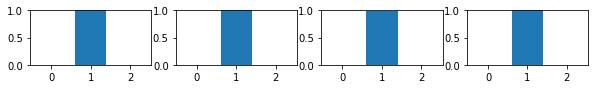

-----------------------------------------
한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 기탁했다. [SEP] 한겨례평화통일포럼은 20키로 쌀로 기탁했다.


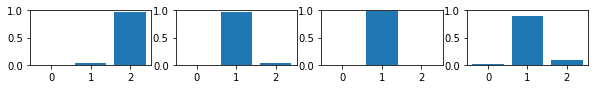

-----------------------------------------
근데 디즈니 꺼라는 건 생각 못했었다. [SEP] 디즈니 소유라는 것은 전혀 몰랐다.


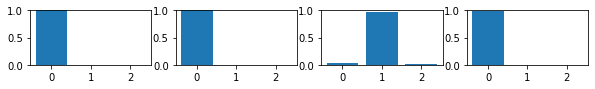

-----------------------------------------
도보 1분거리에 세븐일레븐이 있습니다. [SEP] 세븐일레븐은 걸어서 1분 정도 걸립니다.


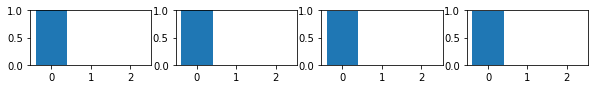

-----------------------------------------
무엇보다도 침실에서 보이는 뷰가 너무 좋았어요 [SEP] 뷰가 너뮤 좋았어요.


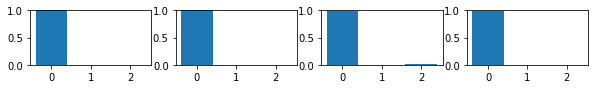

-----------------------------------------
불편사항은 24시간 신고할 수 있다. [SEP] 불편사항은 새벽에도 신고할 수 있다.


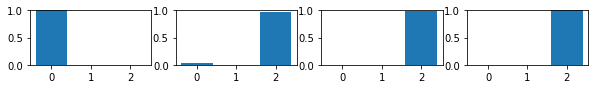

-----------------------------------------
세번째는 숙소로 가는 길이 매우 매우 으슥합니다 [SEP] 모든 숙소로 가는 길은 밝고 안전합니다.


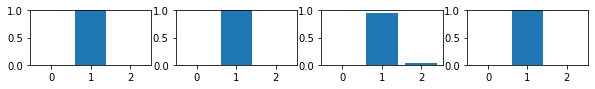

-----------------------------------------
동해안은 전날 밤부터, 남해안과 제주도는 3일부터 너울로 인한 높은 물결이 해안 도로나 방파제를 넘을 것으로 보여 사고에 유의할 필요가 있다. [SEP] 동해안은 3일부터 너울로 인한 높은 물결이 방파제를 넘을 것으로 보인다.


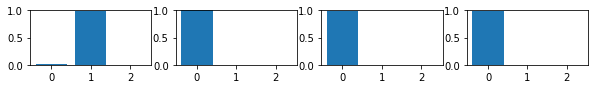

-----------------------------------------
그 1등이 한순간의 방심으로 바뀔 수도 있고, 노력으로 조금씩 성장해 정신을 차려보니 바뀌어 있을 수도 있다. [SEP] 1등은 아무리 노력해도 바뀌지 않는다.


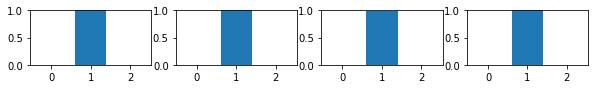

-----------------------------------------
아직 정확한 인명 피해는 아직 집계되지 않았으며, 막대한 경제적 손실이 발생할 것으로 예상된다. [SEP] 인명피해는 약 20명으로 집계되었다.


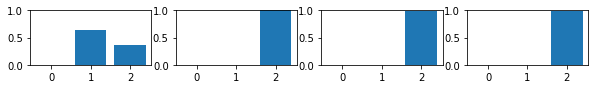

-----------------------------------------
그래서 여기 평점 후한 사람들 중 알바 아닌 사람들도 있을거다 믿는다. [SEP] 평점을 후한 사람들 중에는 자발적으로 작성한 사람도 있을 것이다.


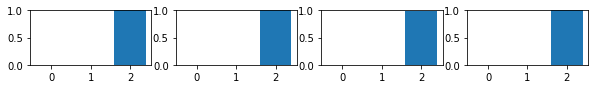

-----------------------------------------
낼부터 불평과 후회는 줄일 수 있을거같다 [SEP] 아직까지는 불평과 후회는 계속할 것 같다.


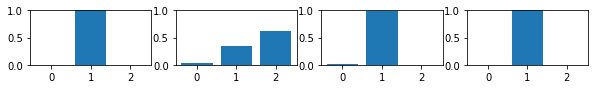

-----------------------------------------
2012년 도입 이후 올해로 4회를 맞은 한국관광 100선은 직전 100선 평가, 지자체 추천, 빅데이터 분석 등을 통해 예비 후보 발굴로 시작한다. [SEP] 한국관광 100선은 내정된 작품이 있다.


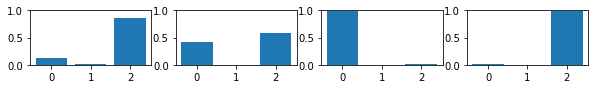

-----------------------------------------
한편 렉터 박사가 조금씩 흘려준 정보를 바탕으로 버팔로 빌의 거주지를 알아낸 스탈링은 사투 끝에 그를 사살하고 상원의원의 딸을 구하는 데 성공한다. [SEP] 스탈링은 버팔로 빌의 거주지를 알아내지 못했다.


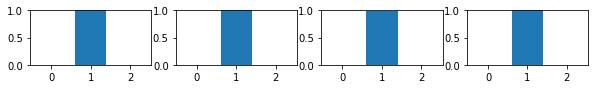

-----------------------------------------
다른 디즈니의 공주들과는 다른 벨 매력적이다 [SEP] 벨은 다른 디즈니의 공주들과는 다른 매력이 있다.


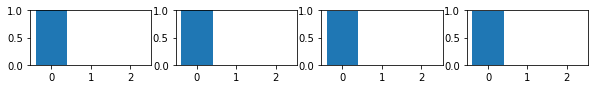

-----------------------------------------
2025년까지 160조원을 투입해 미래형 산업 중심으로 190만개 일자리를 만들겠다는 구상이다. [SEP] 2025년까지 일자리 창출을 위한 투자를 줄여나갈 예정이다.


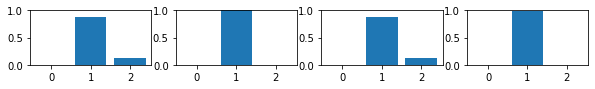

-----------------------------------------
냉각재는 원자로에서 발생하는 열을 흡수하여, 열교환기를 거치면서 외부로 전달하는 역할을 한다. [SEP] 냉각재의 재료는 해외로부터 수입한다.


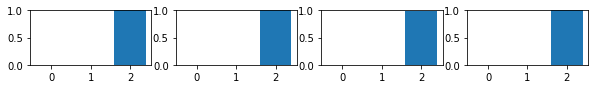

-----------------------------------------
내일인 2012년 12월 6일, 아침 서울기온은 영하 10도, 철원은 영하 15도까지 떨어질 것으로 전망된다. [SEP] 서울과 철원 둘 다 아침 기온이 영하일 것으로 예상된다.


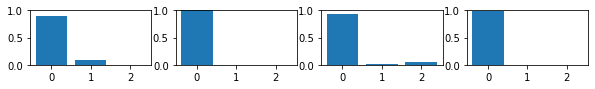

-----------------------------------------
비과학적인 것은 일체 믿지 않는 잡지 편집자 진초게 하나메는 담당하는 잡지가 휴간되자 회사를 그만둔다. [SEP] 진초게는 회사를 옮기게 된다.


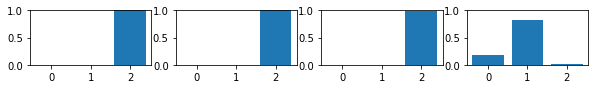

-----------------------------------------
분명 민우는 운명을 바꿀 수 있었다. [SEP] 민우는 미래에 운명을 바꿀 수 있다.


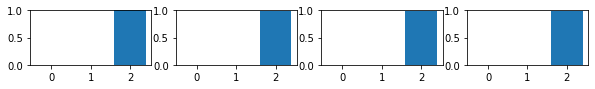

-----------------------------------------
2부는 화려한 수식어가 필요 없는 뮤지컬 갈라 콘서트로 꾸려진다. [SEP] 1부는 지역유지의 논설로 꾸려졌다.


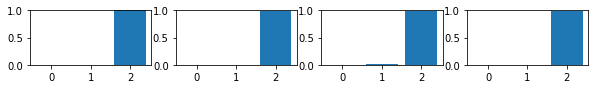

-----------------------------------------
방 대여비 이상의 가치가 있다고 생각됩니다. [SEP] 방 대여비 이하의 가치가 있다고 생각합니다.


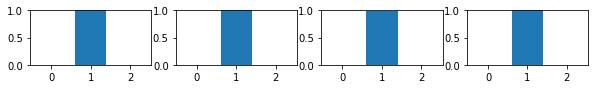

-----------------------------------------
내가 초등학생때 주말의명화에서 봤었다. [SEP] 내가 초등학생때 주말의 명화는 가장 인기있는 프로그램중 하나였다.


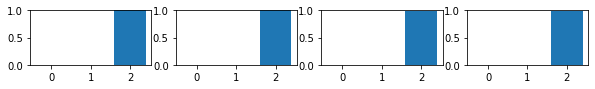

-----------------------------------------
발전소 건설, 운영과정에서만 4만3000여명의 고용도 창출됐다. [SEP] 발전소 건설은 일자리 창출 효과가 있다.


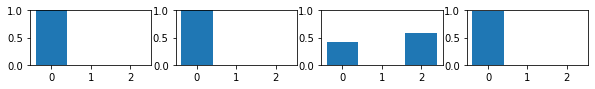

-----------------------------------------
환하고 전망이 좋은 8층 아파트입니다. [SEP] 7층 아파트입니다.


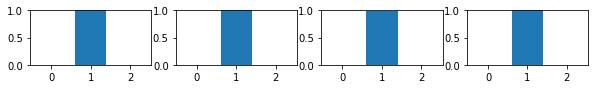

-----------------------------------------
공수처 출범에 앞서 개정이 필요한 15개 대통령령도 일괄개정했다. [SEP] 공수처 출범에 앞서 개정된 대통령령은 15개이다.


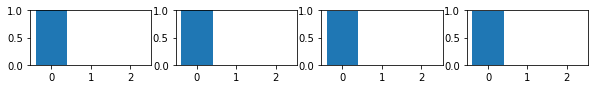

-----------------------------------------


In [123]:
for _ in range(50):
    print(X_test[_])
    plt.figure(figsize=(10, 1))
    plt.subplot(1, 4, 1)
    plt.bar(['0', '1', '2'], roberta_large_probs[_])
    plt.ylim((0,1))

    plt.subplot(1, 4, 2)
    plt.bar(['0', '1', '2'], electra_probs[_])
    plt.ylim((0,1))

    plt.subplot(1, 4, 3)
    plt.bar(['0', '1', '2'], kobert_probs[_])
    plt.ylim((0,1))

    plt.subplot(1, 4, 4)
    plt.bar(['0', '1', '2'], robert_base_prob[_])
    plt.ylim((0,1))
    
    plt.show()
    print('-----------------------------------------')


<BarContainer object of 3 artists>

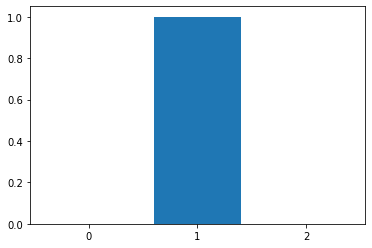

In [95]:
kobert_probs[:5]

array([[7.40597316e-04, 9.97669160e-01, 1.59018370e-03],
       [1.28431339e-03, 8.71660246e-04, 9.97843981e-01],
       [1.21510532e-02, 7.83758762e-04, 9.87065196e-01],
       [3.08253663e-03, 5.46654128e-02, 9.42252040e-01],
       [2.93446958e-01, 6.93863750e-01, 1.26892906e-02]])

In [96]:
robert_base_prob[:5]

array([[4.35163936e-04, 9.99234915e-01, 3.29935778e-04],
       [1.21936004e-03, 3.45633278e-04, 9.98434961e-01],
       [9.09970522e-01, 6.53927680e-04, 8.93755779e-02],
       [3.25018395e-04, 9.99221921e-01, 4.53016808e-04],
       [6.77377045e-01, 3.18491668e-01, 4.13132459e-03]])

## 제출

In [124]:
sum_probs = roberta_large_probs + electra_probs + kobert_probs + robert_base_prob

In [41]:
pred = []
for roberta, electra, kobert in zip(sum_hard[0], sum_hard[1], sum_hard[2]):
    counter = Counter([roberta, electra, kobert])

    pred.append(counter.most_common(1)[0][0])

In [ ]:
result

In [34]:
conter = Counter([roberta, electra, kobert])

In [37]:
conter.most_common(1)[0][0]

1

In [125]:
pred = sum_probs.argmax(axis=1)
pred

array([1, 2, 0, ..., 2, 2, 2])

In [126]:
label_dict1 = {0:"entailment" , 1: "contradiction" , 2:"neutral"}

sample_submission['label'] = [label_dict1[_] for _ in pred]

In [127]:
sample_submission.head(5)

,index,label
0,0,contradiction
1,1,neutral
2,2,entailment
3,3,contradiction
4,4,contradiction


In [128]:
sample_submission.to_csv(dataPATH + 'four_ensem_soft.csv', index=False)

In [45]:
a = pd.DataFrame({'roberta' : sum_hard[0],
                  'electra' : sum_hard[1],
                  'kobert' : sum_hard[2]})

In [47]:
a.head(30)

,roberta,electra,kobert
0,1,1,1
1,2,2,2
2,0,0,2
3,1,1,2
4,1,1,1
5,2,2,2
6,2,2,2
7,2,2,0
8,0,0,0
9,2,2,2
